In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC, SVR

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from matplotlib.pylab import rcParams
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, precision_recall_curve,balanced_accuracy_score,make_scorer,f1_score,classification_report

In [5]:
df = pd.read_csv("/Users/tatianalysynchuk/Desktop/Projekty/GIT/Czy leci z nami pilot/AviationData.csv", usecols = ['Event.Id','Investigation.Type','Event.Date', 'Location','Aircraft.damage','Make','Model','Engine.Type','Number.of.Engines','Purpose.of.flight','Weather.Condition','Broad.phase.of.flight','Injury.Severity','Total.Fatal.Injuries'], parse_dates = ['Event.Date'], encoding = "ISO-8859-1")

/var/folders/4h/y4khv0tn75l0yw98wz0bhhq40000gn/T/ipykernel_14634/1923118374.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/tatianalysynchuk/Desktop/Projekty/GIT/Czy leci z nami pilot/AviationData.csv", usecols = ['Event.Id','Investigation.Type','Event.Date', 'Location','Aircraft.damage','Make','Model','Engine.Type','Number.of.Engines','Purpose.of.flight','Weather.Condition','Broad.phase.of.flight','Injury.Severity','Total.Fatal.Injuries'], parse_dates = ['Event.Date'], encoding = "ISO-8859-1")


In [6]:
# z kolumny 'Event.Date' wyciągamy do osobnych kolumn rok, miesiąc i dzień
df['Year'] = df['Event.Date'].dt.year
df['Month'] = df['Event.Date'].dt.month_name()
df['Day'] = df['Event.Date'].dt.day_name()

# z kolumny 'Location' wyciągamy do osbnych kolumn miasto i stan
df['City'] = df['Location'].str.split(',').str[0]
df['State'] = df['Location'].str.split(',').str[1]

# 'Unk' i 'UNK' zamieniamy na jedną wartość 'Unknown'
df['Weather.Condition'].replace(to_replace = ['Unk', 'UNK'], value = 'Unknown', inplace = True)

# wartości np. Fatal(1), Fatal(123) zamieniamy na jedną wartość 'Fatal'
df['Injury.Severity'] = df['Injury.Severity'].str.replace('Fatal.*', 'Fatal')

# puste wartości uzupełniamy najczęściej występującymi wartościami w danej kolumnie
df['Purpose.of.flight'] = df['Purpose.of.flight'].fillna(df['Purpose.of.flight'].mode()[0])
df['Weather.Condition'] = df['Weather.Condition'].fillna(df['Weather.Condition'].mode()[0])
df['Engine.Type'] = df['Engine.Type'].fillna(df['Engine.Type'].mode()[0])
df['Model'] = df['Model'].fillna(df['Model'].mode()[0])

# w kolumnie number.of.Engines średnia oraz mediana jest podabna, wiec uzupełniam puste wartosci medianą
df['Number.of.Engines'].fillna(df['Number.of.Engines'].median(), inplace=True)

/var/folders/4h/y4khv0tn75l0yw98wz0bhhq40000gn/T/ipykernel_14634/850482051.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Injury.Severity'] = df['Injury.Severity'].str.replace('Fatal.*', 'Fatal')


In [7]:
df = df.dropna()

In [8]:
df.groupby('Broad.phase.of.flight')['Total.Fatal.Injuries'].agg(['count', 'min', 'max', 'mean', 'sum'])

,count,min,max,mean,sum
Broad.phase.of.flight,,,,,
Approach,5415,0.0,228.0,0.705263,3819.0
Climb,1649,0.0,230.0,1.056398,1742.0
Cruise,8391,0.0,111.0,0.721249,6052.0
Descent,1454,0.0,82.0,0.621733,904.0
Go-around,1116,0.0,37.0,0.524194,585.0
Landing,11614,0.0,34.0,0.042793,497.0
Maneuvering,7104,0.0,68.0,0.741132,5265.0
Other,96,0.0,11.0,0.875000,84.0
Standing,553,0.0,34.0,0.195298,108.0


In [9]:
df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Year
count,49498.000000,49498.000000,49498.000000
mean,1.134470,0.486040,1990.650693
std,0.410456,2.872832,6.206839
min,0.000000,0.000000,1948.000000
25%,1.000000,0.000000,1985.000000
50%,1.000000,0.000000,1990.000000
75%,1.000000,0.000000,1996.000000
max,4.000000,265.000000,2007.000000


In [10]:
df = df.reset_index()

___

In [11]:
df['Total.Fatal.Injuries_encoded'] = df['Total.Fatal.Injuries'].where(df['Total.Fatal.Injuries'] ==0, other=1)

In [12]:
df['Total.Fatal.Injuries_encoded'].value_counts()

0.0    38128
1.0    11370
Name: Total.Fatal.Injuries_encoded, dtype: int64

In [13]:
df_X = df[['Number.of.Engines', 'Engine.Type','Purpose.of.flight', 'Weather.Condition', 'Broad.phase.of.flight', 'Month']]

In [14]:
list_to_encode = [
   'Number.of.Engines', 'Engine.Type','Purpose.of.flight', 'Weather.Condition', 'Broad.phase.of.flight', 'Month'
]

X_dummies = pd.get_dummies(df_X, columns = list_to_encode)
X_dummies.head()

,Number.of.Engines_0.0,Number.of.Engines_1.0,Number.of.Engines_2.0,Number.of.Engines_3.0,Number.of.Engines_4.0,Engine.Type_Reciprocating,Engine.Type_Turbo Fan,Engine.Type_Turbo Jet,Engine.Type_Turbo Prop,Engine.Type_Turbo Shaft,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y = df['Total.Fatal.Injuries_encoded']

In [16]:
y

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
49493    0.0
49494    1.0
49495    1.0
49496    1.0
49497    1.0
Name: Total.Fatal.Injuries_encoded, Length: 49498, dtype: float64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3,random_state=123)

In [33]:
xgb_cl = xgb.XGBClassifier(random_state=123, max_depth = 5, n_estimators= 74)

In [34]:
xgb_cl.fit(X = X_train,y =  y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=74, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [44]:
y_pred = xgb_cl.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89     11499
         1.0       0.65      0.46      0.54      3351

    accuracy                           0.82     14850
   macro avg       0.75      0.69      0.71     14850
weighted avg       0.81      0.82      0.81     14850



In [35]:
preds = xgb_cl.predict(X_test)
probas = xgb_cl.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, probas), f1_score(y_test, preds)

(0.814638144419497, 0.5377176015473888)

In [45]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy score:: ", acc)

Accuracy score::  0.822962962962963


In [47]:
confusion_matrix(y_test, y_pred)

array([[10692,   807],
       [ 1822,  1529]])

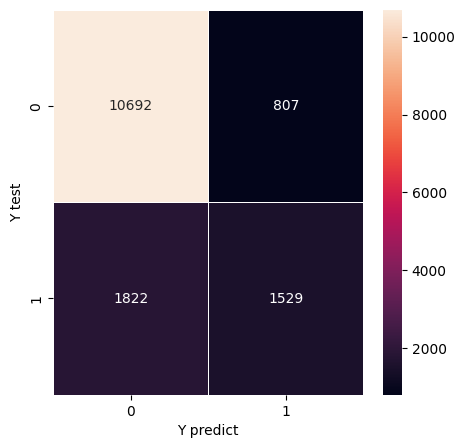

In [48]:
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, fmt='g', ax=ax)
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()